# Implementation of Neural Network Classification model from scratch with PyTorch


## 0. Import Libraries

In [1]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

## 1. Data

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [5]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

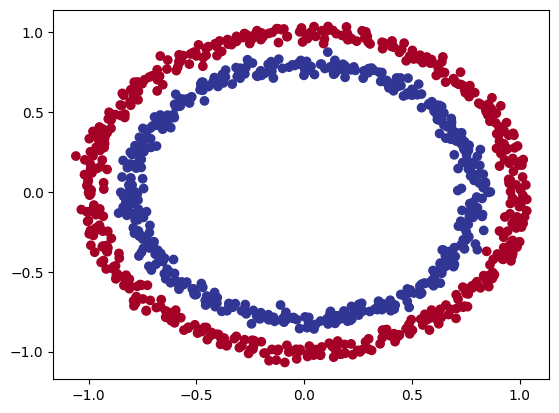

In [7]:
# Visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Let's build a PyTorch neural network model to classify dots into red (0) or blue (1).

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Nural Network Classification model

In [15]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
X_train.shape, y.shape

(torch.Size([800, 2]), torch.Size([1000]))

In [17]:
# Create the classification model
class ClassificationNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=100)
        self.layer_3 = nn.Linear(in_features=100, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.layer_1(x)
      x = self.relu(x)
      x = self.layer_2(x)
      x = self.relu(x)
      x = self.layer_3(x)
      return x

model_0 = ClassificationNN().to(device)
model_0

ClassificationNN(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [18]:
next(model_0.parameters()).device

device(type='cpu')

### 2.1 Loss function and optimizer

In [19]:
# Loss Binary Cross Entropy With Logits
loss_fn = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                         lr=0.1)

In [20]:
# Define accuracy metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Model training

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  model_0.train()

  # Forward pass and squeeze
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)

  # Optimize zero grad
  optimizer.zero_grad()

  # Backpropagation - Loss backward
  loss.backward()

  # Optimize the step
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    # Forward pass and squeeze
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                      y_pred=test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69117, Acc: 59.13% | Test loss: 0.69239 Test acc: 59.50%
Epoch: 100 | Loss: 0.66347, Acc: 76.25% | Test loss: 0.66968 Test acc: 70.50%
Epoch: 200 | Loss: 0.60171, Acc: 96.88% | Test loss: 0.61504 Test acc: 91.50%
Epoch: 300 | Loss: 0.45009, Acc: 99.88% | Test loss: 0.47683 Test acc: 98.50%
Epoch: 400 | Loss: 0.24754, Acc: 100.00% | Test loss: 0.28588 Test acc: 99.50%
Epoch: 500 | Loss: 0.13497, Acc: 100.00% | Test loss: 0.17357 Test acc: 99.50%
Epoch: 600 | Loss: 0.07619, Acc: 100.00% | Test loss: 0.10886 Test acc: 99.50%
Epoch: 700 | Loss: 0.04964, Acc: 100.00% | Test loss: 0.07724 Test acc: 100.00%
Epoch: 800 | Loss: 0.03570, Acc: 100.00% | Test loss: 0.05968 Test acc: 100.00%
Epoch: 900 | Loss: 0.02741, Acc: 100.00% | Test loss: 0.04870 Test acc: 100.00%


In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


## 4. Visualizing decision boundaries

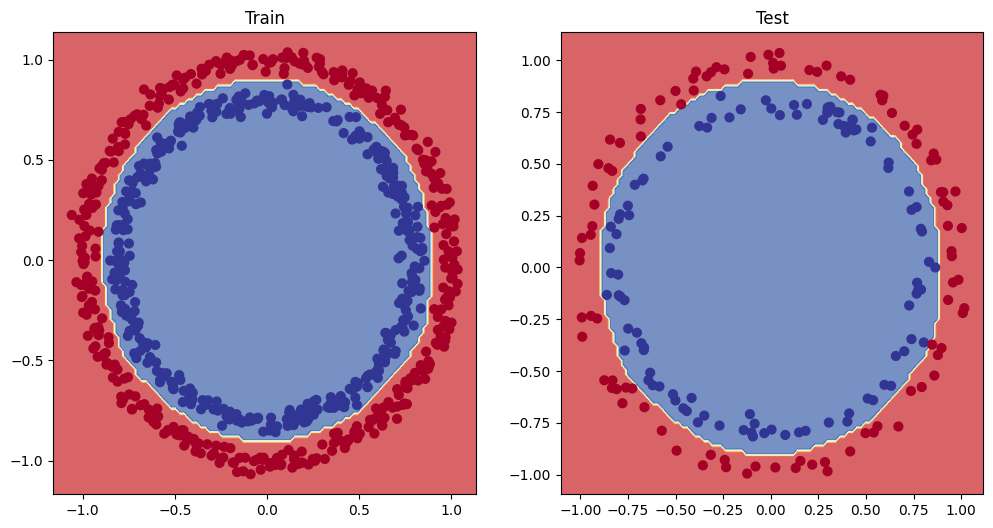

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Implementation of Neural Network Classification model from scratch with PyTorch

### Mateusz Cedro